# Design Alterations

After defining a table, modifications to its table definition in the DataJoint table class will have no effect.
The `definition` string is only used at table definition time and is ignored if the corresponding table already exists.

Changes in schema design are often accomplished by schema migration, i.e. defining new tables and migrating the data into them and then dropping the old tables. 

In [ ]:

import datajoint as dj
schema = dj.schema('university')
schema.spawn_missing_classes()

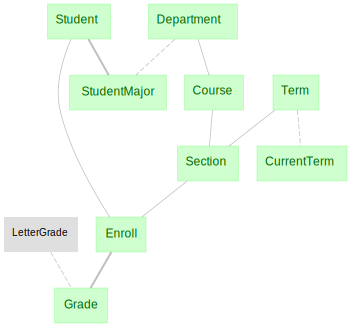

In [5]:
dj.Diagram(schema)

Let's define table `Exam` to contain the results of midterm and final exams.

In [6]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    score  : decimal(5,2)   # percent of total 
    """

In [7]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,score percent of total


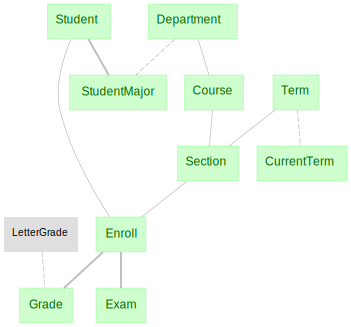

In [8]:
dj.Diagram(schema)

Let's change the definition to record the exam date too

In [9]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll
    ---
    exam_date : date
    score  : decimal(5,2)   # percent of total 
    """

Even though we updated the `definition` in the class, the change is not reflected on the server:

In [10]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,score percent of total


You can examine the definition on the server using the `describe` method:

In [14]:
print(Exam.describe())

-> Enroll
---
score                : decimal(5,2)                 # percent of total



In [15]:
Exam.heading

# 
student_id           : int unsigned                 # university-wide ID number
dept                 : varchar(6)                   # abbreviated department name, e.g. BIOL
course               : int unsigned                 # course number, e.g. 1010
term_year            : year                         # 
term                 : enum('Spring','Summer','Fall') # 
section              : char(1)                      # 
---
score                : decimal(5,2)                 # percent of total

One solution is to simply drop the table and declare it again, which is fine when it contains no valuable data. But let's consider the case when the table is already populated and we wish to keep the existing data.  

First, let's insert some exam entries:

In [16]:
# pick 100 random enrollments from the current term
import random
keys = random.sample(((Enroll - Exam) & CurrentTerm).fetch('KEY'), 100)
# assign random scores
for key in keys:
    Exam.insert1(dict(key, score=random.randint(0,10000)/100))

Now we can alter the `Exam` table with the new definition:

In [17]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,score percent of total
1003,BIOL,2010,2024,Fall,b,7.71
1020,CS,3500,2024,Fall,a,9.45
1035,BIOL,2325,2024,Fall,a,40.52
1046,BIOL,1030,2024,Fall,a,22.14
1065,CS,4150,2024,Fall,a,17.47
1090,CS,3810,2024,Fall,c,43.04
1132,MATH,2270,2024,Fall,a,32.52
1143,BIOL,2010,2024,Fall,a,70.06
1179,CS,1410,2024,Fall,b,41.66
1284,BIOL,2010,2024,Fall,a,33.31


We can now use the `alter` method to apply the new definition:

In [18]:
Exam.alter()

OperationalError: (1292, "Incorrect date value: '0000-00-00' for column 'exam_date' at row 1")

Oh! New attributes cannot be added to tables with existing data without providing a default value. Let's update the definition to allow `exam_date` to be empty (default to `null`) and alter the table again.

In [ ]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    score  : decimal(5,2)   # percent of total 
    """

In [ ]:
Exam.alter()

In [ ]:
Exam()

Now let's add some grades for today's exam:

In [ ]:
from datetime import datetime
today = datetime.now().date().isoformat()

In [ ]:
today

In [ ]:
# pick 20 random enrollments from the current term
keys = random.sample(((Enroll - Exam) & CurrentTerm).fetch('KEY'), 20)
# assign random scores
for key in keys:
    Exam.insert1(dict(key, score=random.randint(0,10000)/100, exam_date=today))

In [ ]:
Exam()

Now let's say we want to rename `score` into `exam_score`:

In [ ]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(5,2)   # percent of total 
    """

In [ ]:
# Say NO!
Exam.alter()

Note that rather than renaming, `alter` attempted to drop the old attribute and add the new one. 

To rename, we must indicate the old attribute name in curly brackets as the first thing in the attribute comment:

In [ ]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_score  : decimal(5,2)   # percent of total 
    exam_date = null: date  
    """

In [ ]:
Exam.alter()

In [ ]:
Exam()

The old attribute name is preserved in the comment just in case, but you can remove it with another `alter` command:

In [ ]:
Exam.describe();

In [ ]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(6,3)   # percent of total 
    photocopy: longb  
    """

In [ ]:
Exam.alter()

In [ ]:
Exam()

In [ ]:
Exam.describe();

We can change the data type of an existing attribute as long as the existing data can fit. However, some precision may be lost.

For example, let's attempt to change the `exam_score` attribute into a `tinyint unsigned`. This will result in the rounding of the scores:

In [ ]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : tinyint unsigned  # percent of total 
    """

In [ ]:
Exam.alter()

In [ ]:
Exam()

But if we attmept to change it to `decimal(3,2)`, for example, we may get an error because some values are too large to fit in this data type.

In [ ]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(3,2)   # percent of total 
    """

In [ ]:
Exam.alter()

In [ ]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(5,2)   # percent of total 
    """

In [ ]:
Exam.alter()

In [ ]:
# restored to higher precision but fractional part has been lost:
Exam()

Finally, let's add a table comment and reorder the attributes:

In [ ]:
@schema
class Exam(dj.Manual):
    definition = """
    # Exam taken by a student enrolled in a course section and the grade
    -> Enroll 
    ---
    exam_score  : decimal(5,2)   # percent of total 
    """

In [ ]:
Exam.alter()

In [ ]:
Exam()

In [ ]:
#clean up
Exam.drop()